- Imported libraries 
- Imported dataset 
- Created svm classifier

In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


- Used KDTree for finding the closest point
- Rewrote the optimal_point function around KDTree

In [2]:
from scipy.spatial import KDTree

# Function to find closest point to contour from the non healthy point
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point

# Displacement from A to B 

- We added ```move_from_A_to_B_with_x1_displacement``` to the ```optimal_point()``` function

In [3]:
def move_from_A_to_B_with_x1_displacement(A, B, delta_x1, constrs=[]):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = delta_x1 / D[0]  # D[0] is the x1 component of the direction vector

    if len(constrs) > 0:
        for i in range(D.shape[0]): 
            D[i] = D[i] * (constrs[i])
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

0.5
[3 3 3]
New point P with desired x1 movement: [2.5 3.5 4.5]


In [4]:
from scipy.interpolate import interp1d

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model): 
    x_in = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx1.shape)
    bound_data = []
    contour = plt.contour(xx1, xx2, y_pred, colors='red')
    for collection in contour.collections[:1]:
        for path in collection.get_paths():
            vertices = path.vertices
            x_coords = vertices[:, 0]
            y_coords = vertices[:, 1]
            bound_data.extend(zip(x_coords,y_coords))
    boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
    return boundary_df

# Gets boundary points
def boundary_points(xx1, xx2, model): 
    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, x1_constr=1, x2_constr=1): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 200000
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    D = optimal_datapt - undesired_datapt
    delta_x1 = D[0]
    if desired_class == 1: 
        delta_x1 = delta_x1 * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt

1.07
[-0.27054087 -4.52735398]


array([10.71052127, 10.15573124])

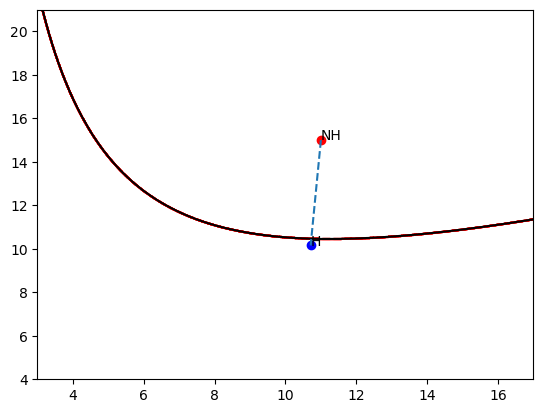

In [5]:
optimal_projection1 = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection1

     x1  x2
0   7.0  20
1   8.0  12
2   9.0  19
3  10.0  17
4  11.0  15
5  13.0  14
6  14.0  12
7  15.0  14
8  15.0  17
9  16.0  16
1.05
[-3.57288938 -0.6407448 ]
1.05
[-0.4127413  -0.69482652]
1.05
[-5.2099653 -1.2938909]
1.05
[-5.21218395 -2.30546576]
1.05
[-0.27054087 -4.52735398]
1.05
[ 0.51421018 -3.36582022]
1.05
[ 0.21448665 -1.2552767 ]
1.05
[ 0.72695907 -2.94918771]
1.05
[ 1.47636923 -5.77057428]
1.05
[ 0.9807346  -4.64298964]


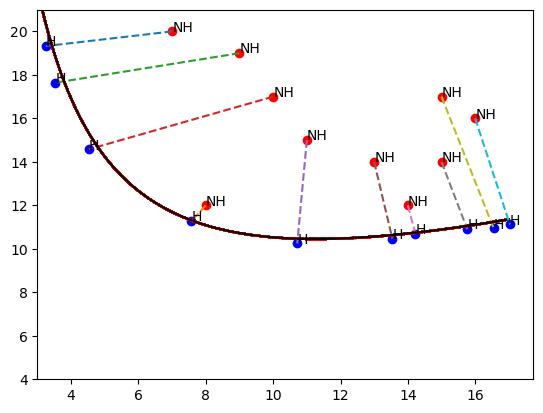

In [6]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
print(undesired_df)
optimal_datapts1 = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), epsilon=0.05)
    optimal_datapts1.loc[len(optimal_datapts1)] = optimal_pt

In [7]:
optimal_datapts1

,x1,x2
0,3.248466,19.327218
1,7.566622,11.270432
2,3.529536,17.641415
3,4.527207,14.579261
4,10.715932,10.246278
5,13.539921,10.465889
6,14.225211,10.681959
7,15.763307,10.903353
8,16.550188,10.940897
9,17.029771,11.124861


- The black line was generated from a set of points where the probability from the classifier matched 0.5 exactly or was sufficiently close to 0.5 (50%) 
- The red line was generated using the boundary function that we have defined above

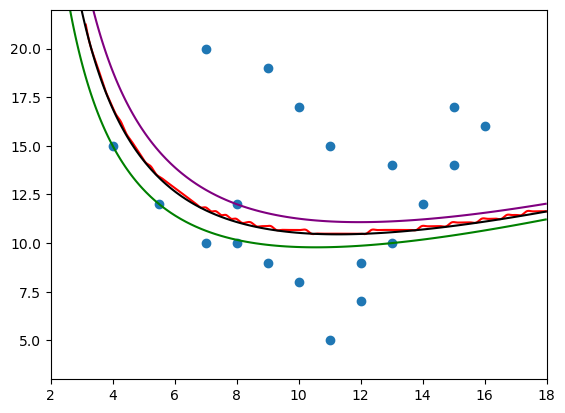

In [ ]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
X=X_train

svm_classifier.fit(X_train, y_train)

X = X_train
x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 100),np.linspace(x2_min, x2_max, 100))
Z = svm_classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
x_in = np.c_[xx1.ravel(), xx2.ravel()]
y_pred = svm_classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx1.shape)

bound_data = []
contour = plt.contour(xx1, xx2, y_pred, colors='black')
for collection in contour.collections[:1]:
    for path in collection.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        bound_data.extend(zip(x_coords,y_coords))
for collection in contour.collections:
    collection.set_visible(False)
boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
N=200000
boundary_df = boundary_df.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

f =            (bound_x, bound_y, kind='cubic')
X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
Y_pred = f(X_pred)
plt.plot(X_pred, Y_pred, c='r')
plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['purple','black','green'])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Applying Constraints on both $X_1$ and $X_2$ 

- Below, we apply the constraints to the magnitude of the direction vector from the original unhealthy point to the decision boundary 
- We apply the constraints independently for each feature $x_1$ and $x_2$ while fixing the other constraint. For instance, we fix $x_2$ feature while changing the scale factor for the direction of the $x_1$ feature. We also do this vice versa for the other feature.

Parameters: 
- Apply $\epsilon = 0.05$ and undesired coordinates $(9,19)$ 

First, we evaluate the ```optimal_point()``` function for the above parameters and get the optimal coordinates $(3.529, 17.641)$

1.05
[-5.2099653 -1.2938909]


array([ 3.52953644, 17.64141455])

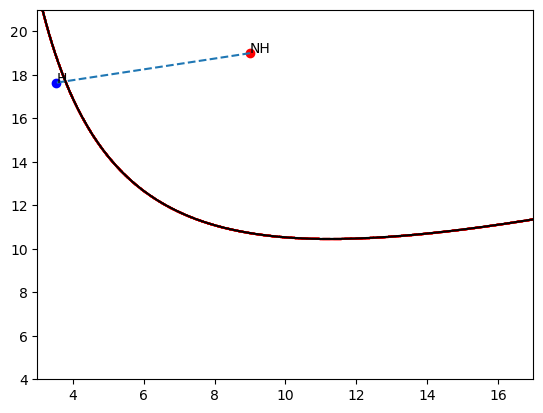

In [9]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(9,19), epsilon=0.05)
optimal_projection

We now fix the $x_2$ feature using the $x_2$ constraint variable and then change the $x_1$ feature across different scales, $0.2, 0.5, 0.8, 0.99$.

1.0
[-1.04199306 -0.25877818]


array([ 7.95800694, 18.74122182])

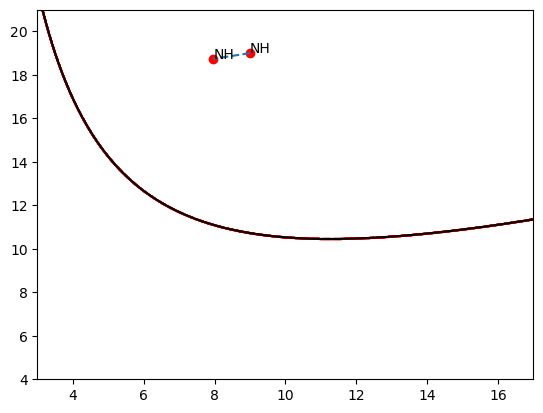

In [10]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.2, x2_constr=0.2)
optimal_projection

1.0
[-2.60498265 -0.25877818]


array([ 6.39501735, 18.74122182])

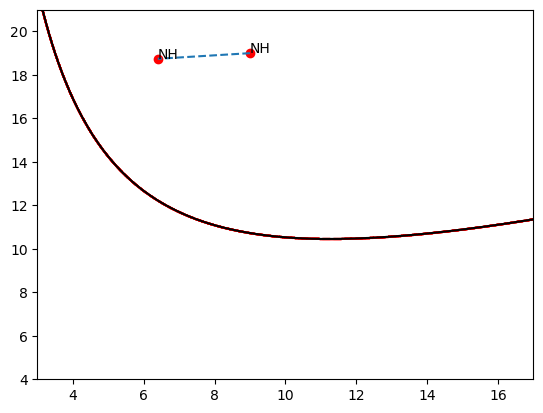

In [11]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.5, x2_constr=0.2)
optimal_projection

1.0
[-4.16797224 -0.25877818]


array([ 4.83202776, 18.74122182])

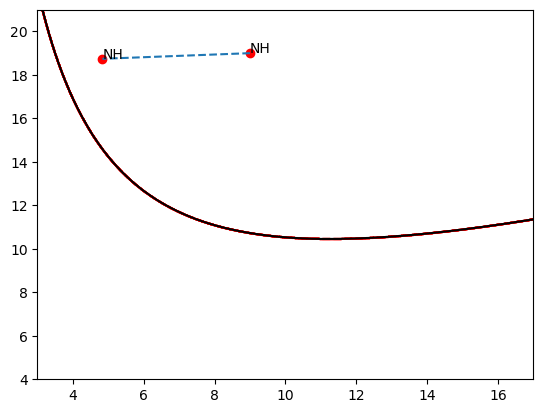

In [12]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.8, x2_constr=0.2)
optimal_projection

1.0
[-5.15786565 -0.25877818]


array([ 3.84213435, 18.74122182])

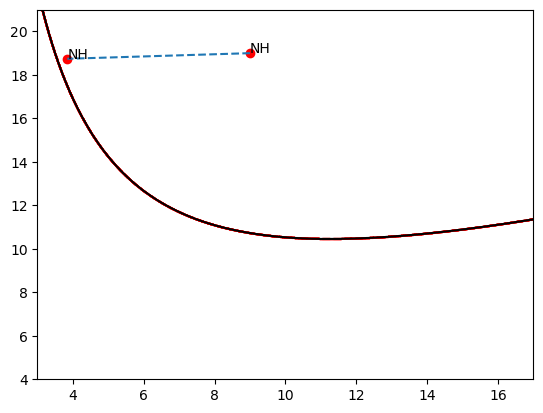

In [13]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.99, x2_constr=0.2)
optimal_projection

We now fix the $x_1$ feature using the $x_1$ constraint variable and then change the $x_2$ feature across different scales, $0.5, 0.8, 0.99$.

1.0
[-1.04199306 -0.64694545]


array([ 7.95800694, 18.35305455])

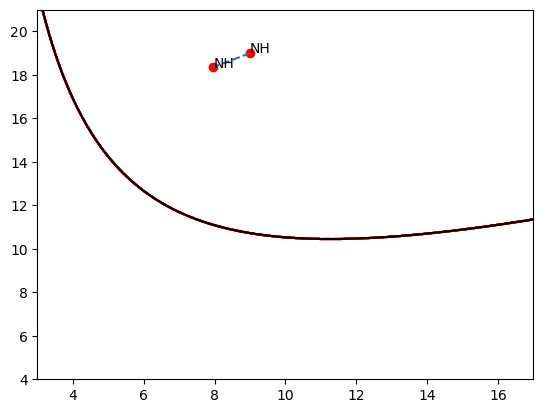

In [14]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.2, x2_constr=0.5)
optimal_projection

1.0
[-1.04199306 -1.03511272]


array([ 7.95800694, 17.96488728])

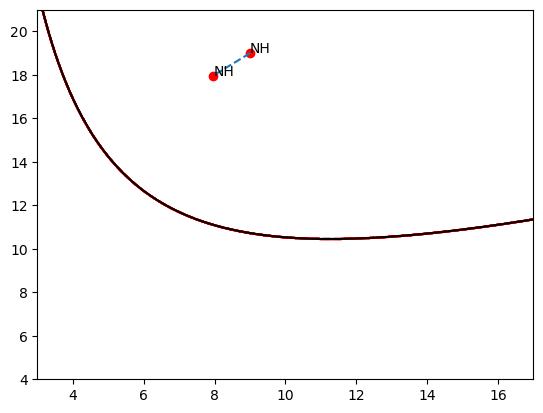

In [15]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.2, x2_constr=0.8)
optimal_projection

1.0
[-1.04199306 -1.280952  ]


array([ 7.95800694, 17.719048  ])

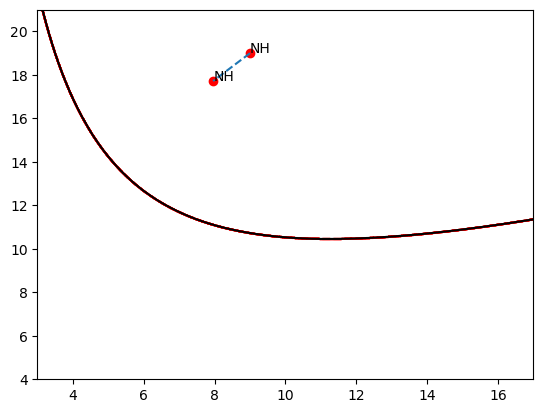

In [16]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.2, x2_constr=0.99)
optimal_projection

1.0
[-1.04199306 -0.25877818]


array([ 7.95800694, 18.74122182])

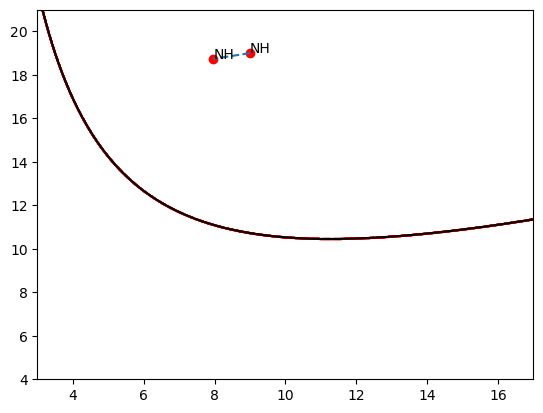

In [17]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.2, x2_constr=0.2)
optimal_projection

1.0
[-2.60498265 -0.64694545]


array([ 6.39501735, 18.35305455])

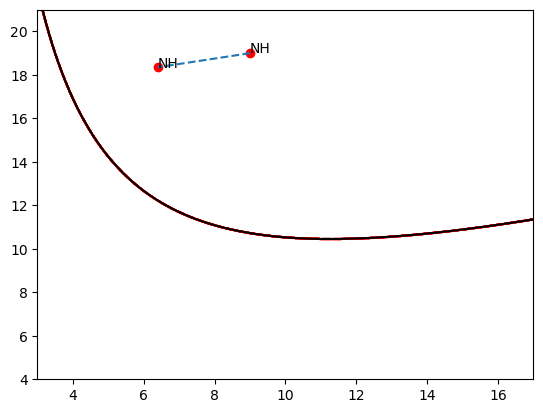

In [18]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.5, x2_constr=0.5)
optimal_projection

1.0
[-4.68896877 -1.16450181]


array([ 4.31103123, 17.83549819])

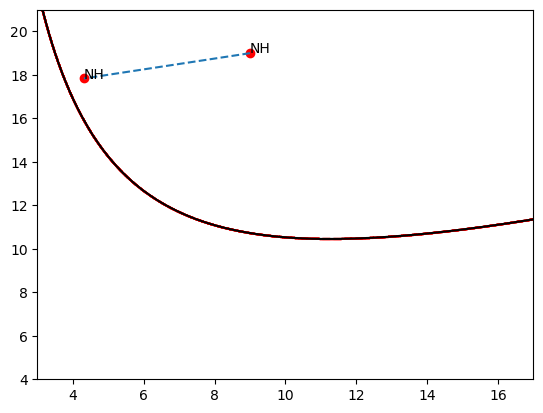

In [19]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(9,19), x1_constr=0.9, x2_constr=0.9)
optimal_projection

# Synthetic Dataset Construction 

- Below, we construct a synthetic dataset consisting of three features. We have two features ```x1``` and ```x2``` and add a third feature to the SVM dataset for the sex of the patient.

In [20]:
import random 
random.seed(0)
synthetic_df = pd.read_csv('processed.cleveland.data')
synthetic_df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                        'fbs', 'restecg', 'thalach', 'exang',
                         'oldpeak', 'slope', 'ca', 'thal', 'num']
synthetic_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


# Removing Categorical Features 

- We remove all categorical features except for only categorical feature, namely the "sex" of the patient

In [21]:
cat_features_removed = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

synthetic_df = synthetic_df.drop(cat_features_removed, axis=1)
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,2
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,2
299,57.0,1.0,130.0,131.0,115.0,1.2,3
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [22]:
synthetic_df.loc[synthetic_df['num'] > 0, 'num'] = 1

In [23]:
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,1
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,1
299,57.0,1.0,130.0,131.0,115.0,1.2,1
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [24]:
from sklearn.model_selection import train_test_split 

X = synthetic_df.drop(columns='num')
y = synthetic_df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(241, 6) (61, 6) (241,) (61,)


In [25]:
X_train

,age,sex,trestbps,chol,thalach,oldpeak
132,51.0,1.0,140.0,261.0,186.0,0.0
202,64.0,0.0,140.0,313.0,133.0,0.2
196,45.0,0.0,138.0,236.0,152.0,0.2
75,60.0,1.0,125.0,258.0,141.0,2.8
176,56.0,1.0,132.0,184.0,105.0,2.1
...,...,...,...,...,...,...
188,69.0,1.0,140.0,254.0,146.0,2.0
71,62.0,1.0,120.0,267.0,99.0,1.8
106,57.0,1.0,128.0,229.0,150.0,0.4
270,66.0,1.0,160.0,228.0,138.0,2.3


In [26]:
duplicates = X_train.duplicated()
duplicates.any()

False

In [27]:
y_train

132    0
202    0
196    0
75     1
176    1
      ..
188    1
71     1
106    1
270    0
102    0
Name: num, Length: 241, dtype: int64

# Working with Categorical Features

- We want to generalize the decision boundary function for any $N$ number of features including $C$ categorical features. 
- We want to ensure that the search space is only $N-C$ whereas the model fits on the entire $N$ set of features. 

# Using the Synthetic Dataset 

- Below, we use the synthetic dataset constructed from three features (two from the original SVM dataset and one categorical variable for the sex of the patient) 
- As shown below, we return the optimal data point where we exclude the categorical feature "sex"

In [101]:
print(X_train.shape, y_train.shape)

(241, 6) (241,)


In [102]:
svm_classifier.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='poly', probability=True)

In [103]:
ranges = [np.linspace(X_train.iloc[:, j].min() - 0.25, X_train.iloc[:, j].max() + 0.25, 16) for j in range(X_train.shape[1])]
grids = np.meshgrid(*ranges) 

# Stack into a flat array of points (n_points^6 rows, 6 columns)
grid_points = np.vstack([g.ravel() for g in grids]).T

# # Convert to DataFrame with same column names (for consistency)
# # Grid points are not valid since sex is a categorical variable
grid_df = pd.DataFrame(grid_points, columns=X_train.columns)

grid_df

,age,sex,trestbps,chol,thalach,oldpeak
0,28.75,-0.25,93.75,125.75,70.75,-0.250000
1,28.75,-0.25,93.75,125.75,70.75,0.156667
2,28.75,-0.25,93.75,125.75,70.75,0.563333
3,28.75,-0.25,93.75,125.75,70.75,0.970000
4,28.75,-0.25,93.75,125.75,70.75,1.376667
...,...,...,...,...,...,...
16777211,77.25,1.25,192.25,564.25,202.25,4.223333
16777212,77.25,1.25,192.25,564.25,202.25,4.630000
16777213,77.25,1.25,192.25,564.25,202.25,5.036667
16777214,77.25,1.25,192.25,564.25,202.25,5.443333


In [104]:
sex_vector = [0 for _ in range(grid_df.shape[0]//2)]
sex_vector.extend([1 for _ in range(grid_df.shape[0]//2)])
# Add sex column vector (Random)
# Grid points must be a categorical value of 0 or 1 
grid_df['sex'] = sex_vector

In [105]:
# # Get probability predictions (ensure model outputs probabilities)
prob0 = svm_classifier.predict_proba(grid_df)[:, 0] 
prob1 = svm_classifier.predict_proba(grid_df)[:, 1] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 1E-6  # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
boundary_points_scaled = pd.DataFrame(grid_df[boundary_mask], columns=X_train.columns)
print(boundary_points_scaled)

            age  sex  trestbps        chol     thalach   oldpeak
131       28.75    0     93.75  125.750000  140.883333  0.970000
132       28.75    0     93.75  125.750000  140.883333  1.376667
133       28.75    0     93.75  125.750000  140.883333  1.783333
134       28.75    0     93.75  125.750000  140.883333  2.190000
392       28.75    0     93.75  154.983333  140.883333  3.003333
...         ...  ...       ...         ...         ...       ...
16776392  77.25    1    192.25  476.550000  175.950000  3.003333
16776645  77.25    1    192.25  505.783333  175.950000  1.783333
16776646  77.25    1    192.25  505.783333  175.950000  2.190000
16776899  77.25    1    192.25  535.016667  175.950000  0.970000
16777153  77.25    1    192.25  564.250000  175.950000  0.156667

[110448 rows x 6 columns]


In [107]:
sex_vector = [1 for _ in range(grid_df.shape[0]//2)]
sex_vector.extend([0 for _ in range(grid_df.shape[0]//2)])
# Add sex column vector (Random)
# Grid points must be a categorical value of 0 or 1 
grid_df['sex'] = sex_vector

In [139]:
# Get probability predictions (ensure model outputs probabilities)
prob0 = svm_classifier.predict_proba(grid_df)[:, 0] 
prob1 = svm_classifier.predict_proba(grid_df)[:, 1] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 1E-3  # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
contour_pts = pd.DataFrame(grid_df[boundary_mask], columns=X_train.columns)
print(contour_pts)

           age  sex  trestbps        chol  thalach  oldpeak
130       28.5    1      93.5  125.500000    140.9     0.38
131       28.5    1      93.5  125.500000    140.9     0.82
132       28.5    1      93.5  125.500000    140.9     1.26
133       28.5    1      93.5  125.500000    140.9     1.70
391       28.5    1      93.5  154.766667    140.9     2.58
...        ...  ...       ...         ...      ...      ...
16776393  77.5    0     192.5  476.700000    176.1     3.46
16776647  77.5    0     192.5  505.966667    176.1     2.58
16776901  77.5    0     192.5  535.233333    176.1     1.70
16777154  77.5    0     192.5  564.500000    176.1     0.38
16777155  77.5    0     192.5  564.500000    176.1     0.82

[110448 rows x 6 columns]


In [140]:
contour_pts = contour_pts.drop_duplicates(subset=X_train.columns)

In [141]:
print(contour_pts.shape)

(13806, 6)


In [142]:
contour_pts = contour_pts.reset_index(drop=True)

contour_pts

,age,sex,trestbps,chol,thalach,oldpeak
0,28.5,1,93.5,125.500000,140.9,0.38
1,28.5,1,93.5,125.500000,140.9,0.82
2,28.5,1,93.5,125.500000,140.9,1.26
3,28.5,1,93.5,125.500000,140.9,1.70
4,28.5,1,93.5,154.766667,140.9,2.58
...,...,...,...,...,...,...
13801,77.5,0,192.5,476.700000,176.1,3.46
13802,77.5,0,192.5,505.966667,176.1,2.58
13803,77.5,0,192.5,535.233333,176.1,1.70
13804,77.5,0,192.5,564.500000,176.1,0.38


# Find the closest point using KDTree and scattered points of the contour line

In [ ]:
from scipy.spatial import KDTree

# Function to find closest point to contour from the non healthy point
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point

print(X_train.iloc[0,:].shape)
cl_pt = 0(point=np.reshape(X_train.iloc[0,:], (1,-1)), contour=contour_pts)
cl_pt

(6,)


KeyError: "None of [Index([4931], dtype='int64')] are in the [columns]"

# Cubic Interpolation of the dataset

- Structured data vs Unstructured data 
- $R^n \Rightarrow R^n$ versus $R^n \Rightarrow R^1$

In [77]:
from scipy.interpolate import interpn

X = boundary_points_scaled  # Shape: (29004, 6)
y = svm_classifier.predict(X)  # Shape: (29004,)
new_point = [2, 5, 1.5, 3.5, 4.5, 1.5]  # Point to interpolate

# Interpolate using griddata
x_i = interpn(X, y, new_point, method='cubic')  # or 'nearest', 'linear'
print(x_i)

ValueError: There are 29004 point arrays, but values has 1 dimensions

# Nearest Neighbor Interpolation (interpn) of the dataset 

In [ ]:
from scipy.interpolate import NearestNDInterpolator

X = boundary_points_scaled  # Shape: (29004, 6)
y = svm_classifier.predict(X)  # Shape: (29004,)
new_point = [2, 5, 1.5, 3.5, 4.5, 1.5]  # Point to interpolate

# Interpolate using griddata
x_i = NearestNDInterpolator(X, y)  # or 'nearest', 'linear'
print(x_i)

[1]


# RBF Interpolation of the dataset

In [78]:
from scipy.interpolate import RBFInterpolator

X = boundary_points_scaled[:, 0:5]
y = boundary_points_scaled[:, -1]

interpolator = RBFInterpolator(X,y,kernel='gaussian', epsilon=10, smoothing=1e-12)

In [79]:
interpolated_val = interpolator(np.reshape(boundary_points_scaled[0, 0:5], (1,-1)))
interpolated_val

array([1.9866971])

In [80]:
boundary_points_scaled[0]

array([ 28.75      ,   0.        ,  93.75      , 125.75      ,
       140.88333333,   1.37666667])

In [84]:
ranges = [np.linspace(np.min(boundary_points_scaled[:, j], axis=0) - 0.0001, np.max(boundary_points_scaled[:, j], axis=0) + 0.0001, 5) for j in range(boundary_points_scaled.shape[1]-1)]
grids = np.meshgrid(*ranges) 

grid_points = np.vstack([g.ravel() for g in grids]).T

print(grid_points.shape)

(3125, 5)


In [85]:
clf=svm_classifier 
X = grid_points[:, 0:5]

interpolated_vals = interpolator(X)
grid_points = np.append(grid_points, np.reshape(interpolated_vals, (-1,1)), axis=1)
print(grid_points.shape)

(3125, 6)


In [86]:
print(grid_points[1].shape)
clf.predict_proba(np.reshape(grid_points[1000], (1,-1)))

(6,)


array([[0.34143238, 0.65856762]])

# Defining the function without Interpolation

In [99]:

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, x1_constr=1, x2_constr=1): 

    list_feats = np.zeros((20,1))

    X_train=list_feats
    y_train=df['y'].values

    model.fit(X_train, y_train)

    # Out of a collection of N features with C categorical features, we remove C categorical features such that the space only consists of N-C variables
    for col in df.columns:
        
        col_feat = df[col] 
    
        count0   = len(col_feat[col_feat==0])
        count1   = len(col_feat[col_feat==1])

        if col != 'y' and not (len(col_feat) == count0 + count1): 
            np_col = col_feat.to_numpy().reshape(-1,1)
            list_feats = np.append(list_feats, np_col, axis=1)

    list_feats = np.delete(list_feats, 0, axis=1)

    ranges = [np.linspace(X_train.iloc[:, j].min() - 0.5, X_train.iloc[:, j].max() + 0.5, 16) for j in range(X_train.shape[1])]
    grids = np.meshgrid(*ranges) 

    # Stack into a flat array of points (n_points^6 rows, 6 columns)
    grid_points = np.vstack([g.ravel() for g in grids]).T

    # # Convert to DataFrame with same column names (for consistency)
    # # Grid points are not valid since sex is a categorical variable
    grid_df = pd.DataFrame(grid_points, columns=X_train.columns)

    sex_vector = [0 for _ in range(grid_df.shape[0]//2)]
    sex_vector.extend([1 for _ in range(grid_df.shape[0]//2)])
    # Add sex column vector (Random)
    # Grid points must be a categorical value of 0 or 1 
    grid_df['sex'] = sex_vector

    # Get probability predictions (ensure model outputs probabilities)
    prob0 = svm_classifier.predict_proba(grid_df)[:, 0] 

    # Find points near the decision boundary (P(class 1) ≈ 0.5)
    threshold = 1E-6  # Tight threshold for "50%-50%" (adjust as needed)
    boundary_mask = np.abs(prob0 - 0.5) < threshold
    boundary_points_scaled = pd.DataFrame(grid_df[boundary_mask], columns=X_train.columns)

    boundary_points_scaled = boundary_points_scaled.drop(columns=X_train.columns)

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=boundary_points_scaled)

    D = optimal_datapt - undesired_datapt
    delta_x1 = D[0]
    if desired_class == 1: 
        delta_x1 = delta_x1 * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        return optimal_datapt 
    elif desired_class == -1: 
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        return optimal_datapt